In [1]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageDraw import Draw
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from bbox_detector.model import BBoxDetector
from bbox_detector.train import train, load_checkpoint
from bbox_detector.inference import inference
from bbox_detector.utils import *

# Model Training

In [3]:
datatset_path = '../datasets/dataset_v5'

batch_size = 256
num_epochs = 60
lr = 1e-4

conf_threshold=0.90
nms_threshold=0.30

In [4]:
# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Load the dataset
dataset = BBoxDetectorDataset(datatset_path, transform=transform, resize=ResizeWithPad(224))

total_size = len(dataset)
train_size = int(0.90 * total_size)
#val_size = int(0.10 * total_size)
#test_size = total_size - train_size - val_size
val_size = total_size - train_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.transform = transform_noise

# Create the DataLoader for the training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Create the DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [5]:
model = BBoxDetector(dropout_rate=0.4, device=device).to(device)

In [ ]:
model, train_loss_history, val_loss_history, precision_recall_history = train(model, train_loader, val_loader, num_epochs, lr, conf_threshold, nms_threshold, device, checkpoint_dir='bbox_detector/checkpoints')

In [ ]:
# plot loass and precision recall togheter
plot_loss(train_loss_history, val_loss_history)
plot_precision_recall_f1(precision_recall_history)

## Model Loading from Checkpoint

In [7]:
model = BBoxDetector(dropout_rate=0.4, device=device).to(device)
epoch, train_loss_history, val_loss_history, precision_recall_history = load_checkpoint('bbox_detector/checkpoints/model_epoch_40.pth', model, weights_only=False)

/mnt/d/Documents/GitHub/captcha_solver/captcha_solver/bbox_detector/train.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from bbox_detector/checkpoints/model_epoch_40.pth, Epoch: 40


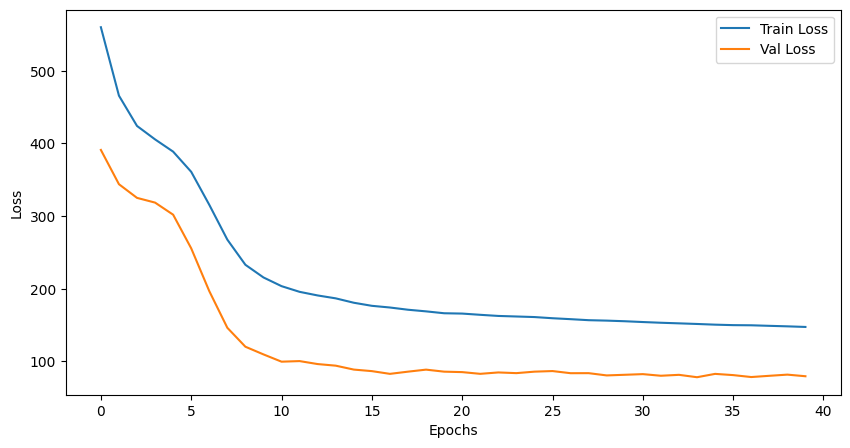

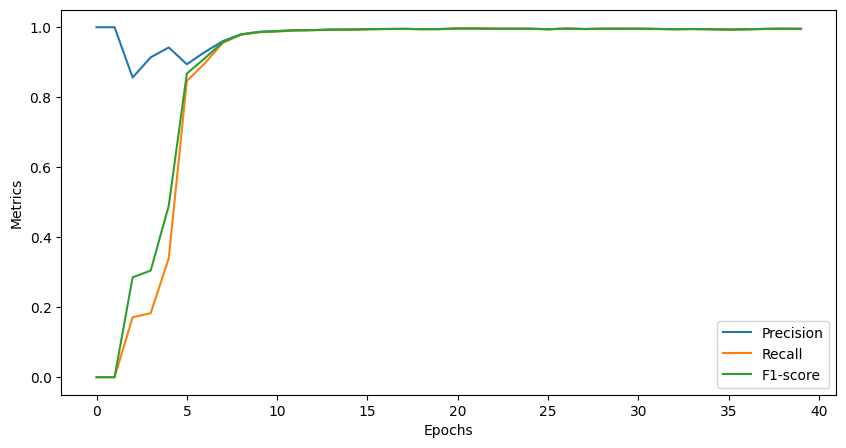

In [8]:
# plot loass and precision recall togheter
plot_loss(train_loss_history, val_loss_history)
plot_precision_recall_f1(precision_recall_history)

## Model Inference Testing

In [4]:
image_path = '../datasets/dataset_v5/98.jpg'
image = Image.open(image_path).convert("RGB")

In [5]:
boxes, scores = inference(model, image, device, conf_threshold=0.95, nms_threshold=0.30)

Raw proposals shape: torch.Size([1, 980, 4])
Objectness logits shape: torch.Size([1, 980, 2])
Max objectness score: 38.42792510986328
Min objectness score: -33.47733688354492
After softmax, max score: 0.9999992847442627
Number of proposals after confidence thresholding: 343
Filtered boxes shape: torch.Size([343, 4])
Filtered scores shape: torch.Size([343])
Number of boxes after NMS: 6


/home/vedo/miniconda3/envs/captcha/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


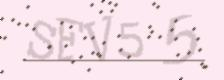

In [6]:
image.show()

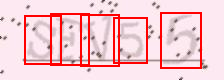

In [7]:
show_image(image, boxes)